# “Given the forecasted weather conditions, how many bicycles can we expect to be rented out (city-wide) this Saturday at 2pm?”

# Information about the data set:

information collected and included
- dteday : date
- season : season (1:winter, 2:spring, 3:summer, 4:fall)
- yr : year (0: 2011, 1:2012)
- mnth : month ( 1 to 12)
- hr : hour (0 to 23)
- holiday : weather day is holiday or not (extracted from [Web Link])
- weekday : day of the week
- workingday : if day is neither weekend nor holiday is 1, otherwise is 0.
- weathersit :
- 1: Clear, Few clouds, Partly cloudy, Partly cloudy
- 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
- 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
- 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
- temp : Normalized temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-8, t_max=+39 (only in hourly scale)
- atemp: Normalized feeling temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-16, t_max=+50 (only in hourly scale)
- hum: Normalized humidity. The values are divided to 100 (max)
- windspeed: Normalized wind speed. The values are divided to 67 (max)
- casual: count of casual users
- registered: count of registered users
- cnt: count of total rental bikes including both casual and registered

import all required libraries and functions

In [883]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
    
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import train_test_split,GridSearchCV


import statsmodels.api as sm
from patsy import dmatrices
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from statsmodels.formula.api import ols
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline

start playing around with the data a little bit

In [884]:
#read the data and look at it and modift it accoding to need
df = pd.read_csv('train.csv')
df_time_index=pd.read_csv('train.csv', index_col=0)
df_time_index.drop(['registered', 'casual'], axis=1, inplace=True) 

In [885]:
#create new variables:

df['year'] = pd.to_datetime(df['datetime']).dt.year
df['month'] = pd.to_datetime(df['datetime']).dt.month
df['day'] = pd.to_datetime(df['datetime']).dt.day
df['hour'] = pd.to_datetime(df['datetime']).dt.hour
df.drop(['casual', 'registered', 'datetime'], axis=1, inplace=True)

# Know the DATA (before the workflow of machine learning)
# 1. Exploratory analysis 

the data has no missing values

-  1.1 Plotting according to time index
-  1.2 Plotting for interaction
-  1.3 Check for collinearity and non-linearity relationship

1.1 Plotting according to datetime

<AxesSubplot:ylabel='Frequency'>

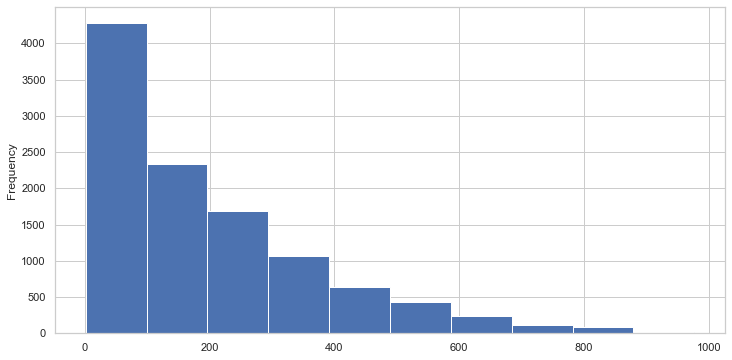

In [887]:
#plot the response
df['count'].plot(kind='hist')

<AxesSubplot:title={'center':'count'}, xlabel='[day]'>

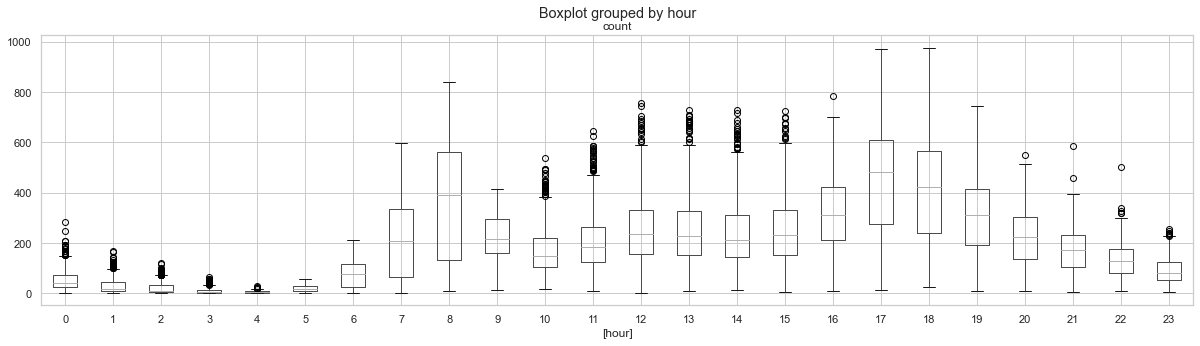

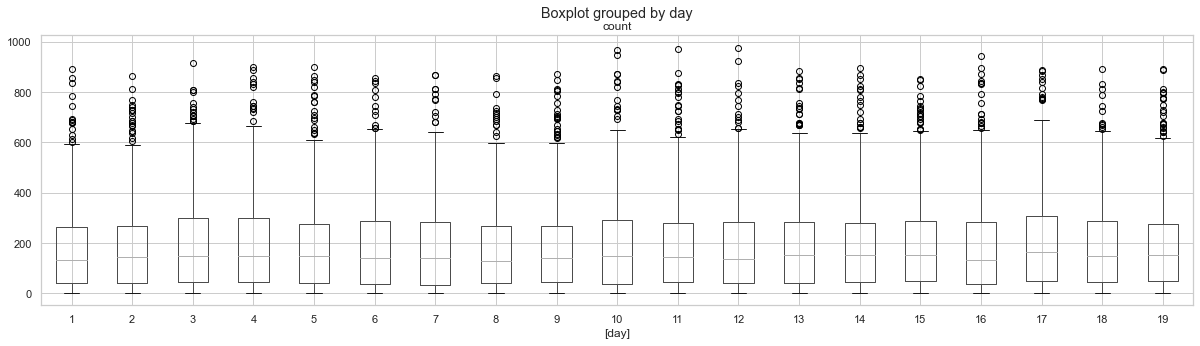

In [888]:
#boxplot for count * hour and count * day:
df.boxplot(column=['count'],figsize=(20, 5), by=['hour'])
df.boxplot(column=['count'],figsize=(20, 5), by=['day'])

<AxesSubplot:xlabel='hour,atemp'>

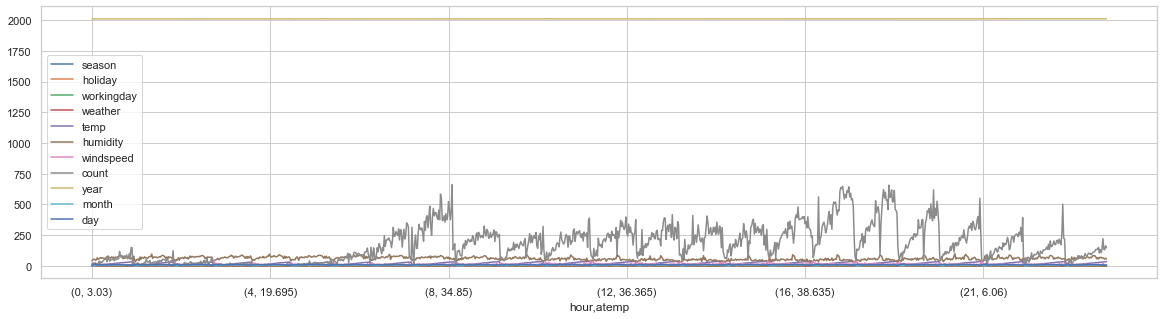

In [889]:
#check an interaction between two factors (season and temperature)
df.groupby(['hour','atemp']).mean().plot(figsize=(20, 5))

<AxesSubplot:xlabel='hour,holiday,workingday,atemp'>

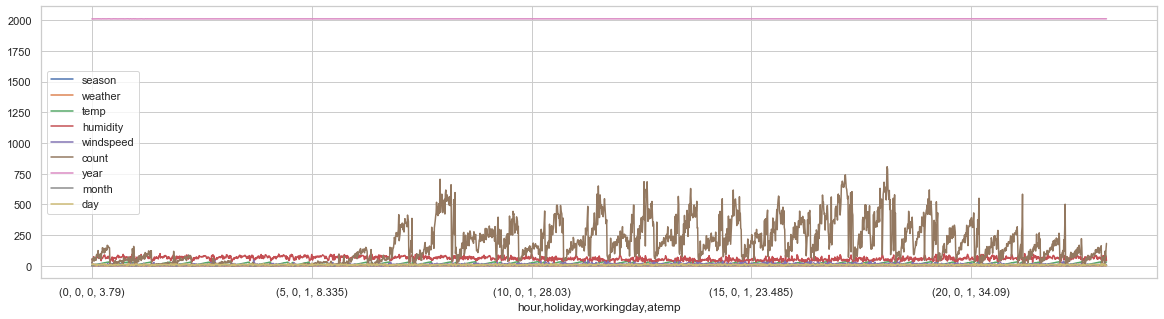

In [890]:
df.groupby(['hour','holiday','workingday', 'atemp']).mean().plot(figsize=(20, 5))

-  1.2 Plotting for interaction

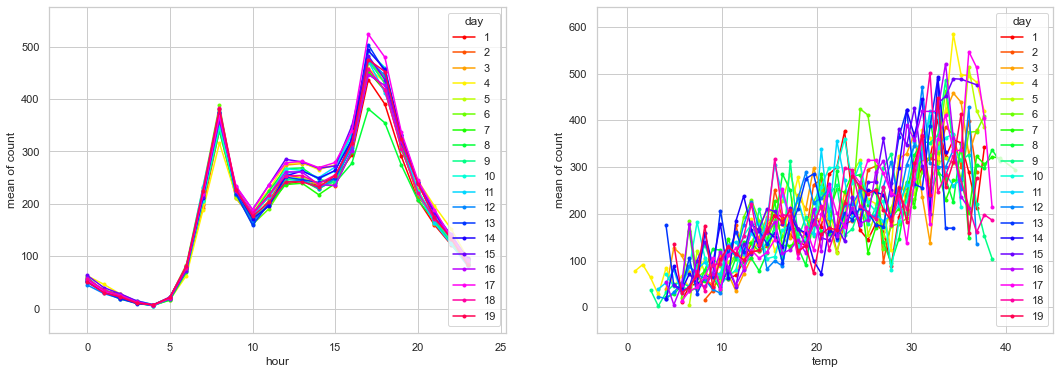

In [891]:
#how the hour is controlling the day when it comes to count
from statsmodels.graphics.factorplots import interaction_plot
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(18, 6))
fig = interaction_plot(
    x=df['hour'],
    trace=df['day'],
    response=df['count'],
    ax=ax[0],
)   

fig = interaction_plot(
    x=df['temp'],
    trace=df['day'],
    response=df['count'],
    ax=ax[1],
)  

### I do not want the variable day .....

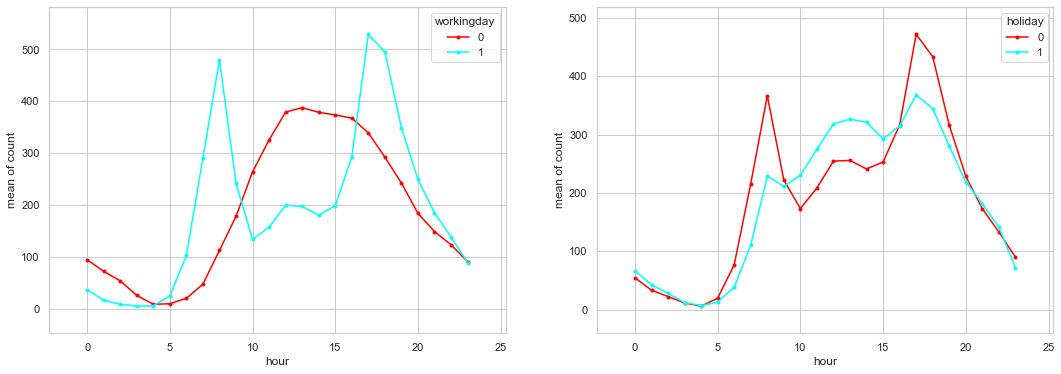

In [892]:
#how the hour is controlling the day when it comes to count
from statsmodels.graphics.factorplots import interaction_plot
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(18, 6))
fig = interaction_plot(
    x=df['hour'],
    trace=df['workingday'],
    response=df['count'],
    ax=ax[0],
)   

fig = interaction_plot(
    x=df['hour'],
    trace=df['holiday'],
    response=df['count'],
    ax=ax[1],
)  


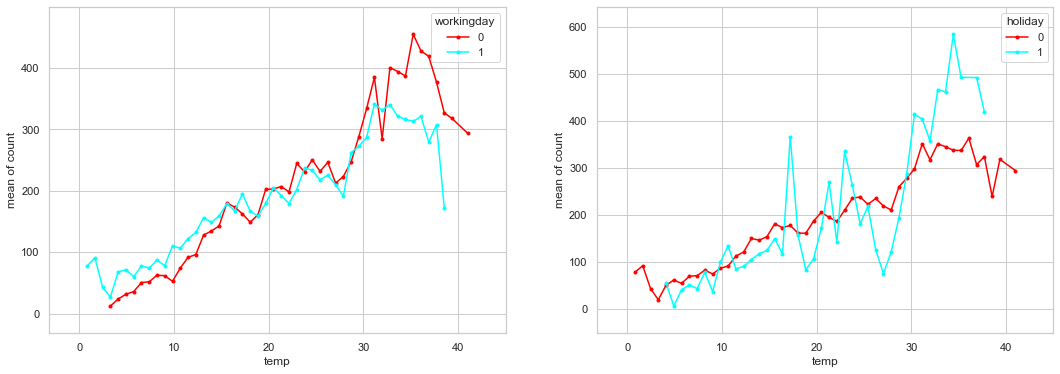

In [893]:
#how the hour is controlling the day when it comes to count
from statsmodels.graphics.factorplots import interaction_plot
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(18, 6))
fig = interaction_plot(
    x=df['temp'],
    trace=df['workingday'],
    response=df['count'],
    ax=ax[0],
)   

fig = interaction_plot(
    x=df['temp'],
    trace=df['holiday'],
    response=df['count'],
    ax=ax[1],
)  
#temperature has a deterimental effect on counts and controls the variable "woringday/holiday"

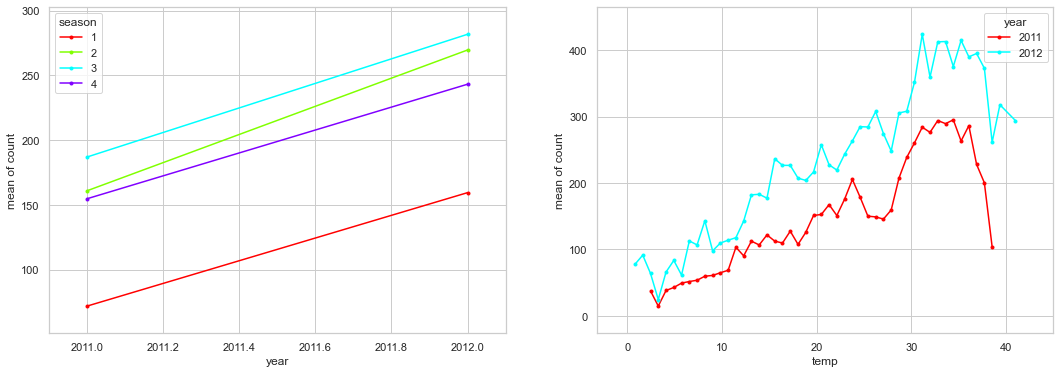

In [894]:
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(18, 6))
fig = interaction_plot(
    x=df['year'],
    trace=df['season'],
    response=df['count'],
    ax=ax[0],
)   

fig = interaction_plot(
    x=df['temp'],
    trace=df['year'],
    response=df['count'],
    ax=ax[1],
)  

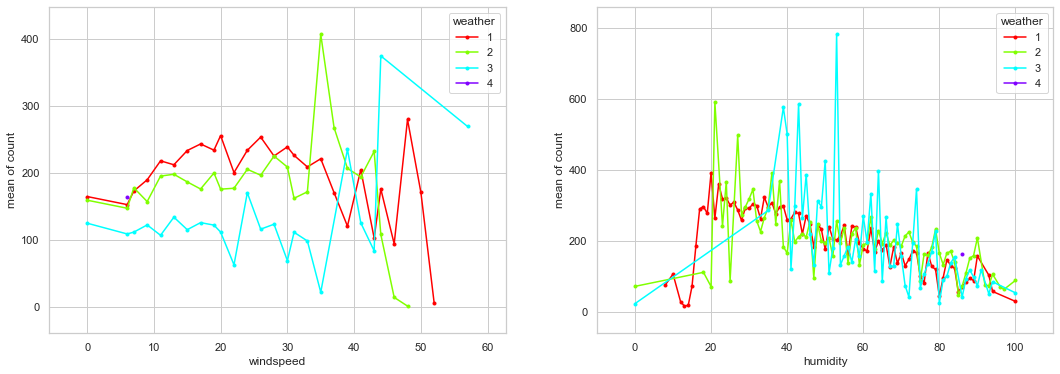

In [895]:
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(18, 6))
fig = interaction_plot(
    x=df['windspeed'],
    trace=df['weather'],
    response=df['count'],
    ax=ax[0],
)   

fig = interaction_plot(
    x=df['humidity'],
    trace=df['weather'],
    response=df['count'],
    ax=ax[1],
)  


-  1.3 Check for collinearity and try separating the data into seasons and hours

In [1023]:
#check for collinearity using variance inflation factor: if VIF is > 5 is BAD!!!!!!!
from statsmodels.stats.outliers_influence import variance_inflation_factor
y, X = dmatrices('count ~ hour+day+temp+atemp+weather+humidity+windspeed+season+workingday+holiday', df, return_type='dataframe')

vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['variable'] = X.columns

vif
# There is a collinearity between temp and atemp 

,VIF,variable
0,41.074016,Intercept
1,1.121588,hour
2,1.002141,day
3,35.527764,temp
4,35.596055,atemp
5,1.248969,weather
6,1.527013,humidity
7,1.201527,windspeed
8,1.137902,season
9,1.071292,workingday


In [1118]:
#I used pipe from pandas to produce quick regressions and interactions
import statsmodels.formula.api as sm  #statsmodel package

#check the regression for holidays in season=3 and weather=1 and hour range 6 to 20....
(df.query('season==3 & hour == 2 & weather == 1').pipe((sm.ols, "data"), "count ~ workingday + hour + temp:humidity +temp:windspeed+ windspeed:humidity").fit().summary())

#lots of fun with statsmodel !!!!!!!!!

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  count   R-squared:                       0.896
Model:                            OLS   Adj. R-squared:                  0.891
Method:                 Least Squares   F-statistic:                     170.7
Date:                Fri, 04 Mar 2022   Prob (F-statistic):           4.84e-38
Time:                        14:27:03   Log-Likelihood:                -312.63
No. Observations:                  84   AIC:                             635.3
Df Residuals:                      79   BIC:                             647.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             17.2368      1.485     11.610      0.000      14.282      20.192
workingday           -62.9757      2.498    -25.208      0.000     -67.948     -58.003
hour                  34.4736      2.969     11.610      0.000      28.563      40.384
temp:humidity         -0.0065      0.004     -1.823      0.072      -0.014       0.001
temp:windspeed        -0.0160      0.022     -0.721      0.473      -0.060       0.028
windspeed:humidity     0.0075      0.008      0.945      0.347      -0.008       0.023
==============================================================================
Omnibus:                        3.993   Durbin-Watson:                   2.164
Prob(Omnibus):                  0.136   Jarque-Bera (JB):                4.441
Skew:                          -0.130   Prob(JB):                        0.109
Kurtosis:                       4.096   Cond. No.                     6.35e+17
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 8.91e-28. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [1025]:
#IMPORTANT NOTES
#  1.non-linearity relationship y-x  plot residuals against the y-hat .. we can log the predictors as solution
#  2. correlation of error terms  .. plot errors as function of time
#  3. non-constant variance .. heteroscedasticity .. transfrom the response using a concave function: log(y).. sqrt(y)7
      # weighted least sequares
#  4. Outliers .. plot studentized error against y-hat.. 
#  5. leverage points... compute leverage statistics
#  6. collinearity or multicollinearity ... compute the variance inflation factor VIF .. >5 is a problem.

#--------------------------------------------------------------
#Extract other quantities of interest:
#print("Parameters: ", res.params)
#print("Standard errors: ", res.bse)
#df.query('season==3 & hour > 6 & hour <21')print("Predicted values: ", res.predict())

## try KNN-regression analysis

# The variables that I need are: season, workingday, holiday, atemp, (hour), weather, humidity in total = 8

# workflow of training my model
# 1. Split to train and test sets


baseline model

In [899]:
#DF.head(2)

In [900]:
y=DF['count'] # the response
X = DF.drop('count', axis=1) # the predictors

In [901]:
x_train, x_test, y_train, y_test= train_test_split(X, y, random_state = 14)

In [902]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((8164, 7), (2722, 7), (8164,), (2722,))

# 2. Explore the datasets

   # plot some variables

In [903]:
#categorical variables
x_train['workingday'].unique(), x_test['workingday'].unique(), x_train['holiday'].unique(), x_test['holiday'].unique(),

(array([1, 0], dtype=int64),
 array([1, 0], dtype=int64),
 array([0, 1], dtype=int64),
 array([0, 1], dtype=int64))

<AxesSubplot:ylabel='Frequency'>

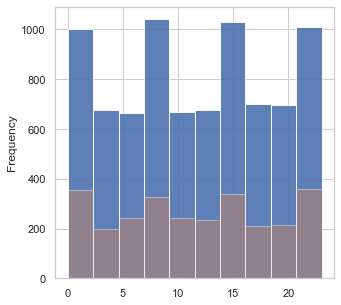

In [1079]:
#check the frequency
x_train['hour'].plot.hist(alpha=0.9,figsize=(5, 5))
x_test['hour'].plot.hist(alpha=0.4,figsize=(5, 5))

<AxesSubplot:ylabel='Frequency'>

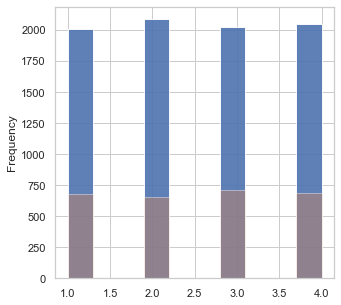

In [1080]:
x_train['season'].plot.hist(alpha=0.9,figsize=(5, 5))
x_test['season'].plot.hist(alpha=0.4,figsize=(5, 5))

<AxesSubplot:ylabel='Frequency'>

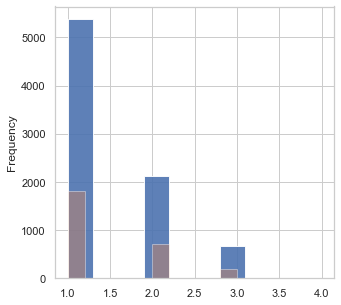

In [1081]:
x_train['weather'].plot.hist(alpha=0.9,figsize=(5, 5))
x_test['weather'].plot.hist(alpha=0.4,figsize=(5, 5))

<AxesSubplot:ylabel='Frequency'>

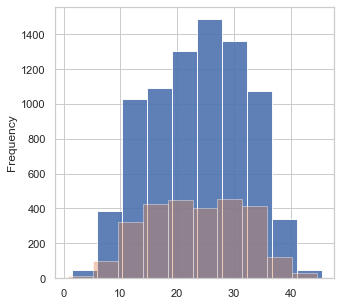

In [1082]:
x_train['atemp'].plot.hist(alpha=0.9,figsize=(5, 5))
x_test['atemp'].plot.hist(alpha=0.4,figsize=(5, 5))

# 3. Feature engineering

-  One-Hot encoding: weather and season
-  scaling for atemp and humidity
-  Binning for variable (hour) into 4 main groups.


In [908]:
#create the features_eng
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.preprocessing import OneHotEncoder
ct = ColumnTransformer(
     [("scale", StandardScaler() , ['atemp', 'humidity']),
      ("Binning", KBinsDiscretizer(n_bins=4), ['hour']),
     ('One-Hot', OneHotEncoder(handle_unknown='ignore'), ['weather', 'season']),
     ('do-nothing', 'passthrough', ['workingday', 'holiday'])])

In [909]:
#fit and transform the training dataset and transform the test dataset
x_train_ct=ct.fit_transform(x_train)
x_test_ct=ct.transform(x_test)

- Check if everything is ok

In [910]:
#check after the ct
pd.DataFrame(x_train_ct).head(2) 

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,0.247027,1.350599,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1,-0.111276,0.779584,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [911]:
pd.DataFrame(x_test_ct).head(2) 

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,0.247027,0.779584,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1,-0.021553,0.052839,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0


<AxesSubplot:ylabel='Frequency'>

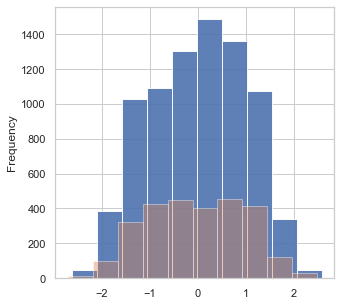

In [1083]:
#check the distribution of atemp
pd.DataFrame(x_train_ct)[0].plot.hist(alpha=0.9,figsize=(5, 5))
pd.DataFrame(x_test_ct)[0].plot.hist(alpha=0.4,figsize=(5, 5))

# 4. Linear regression 
# no polynomial in this model

In [913]:
#try with linear Regression 

In [914]:
lm=LinearRegression()
lm.fit(x_train_ct, y_train)
y_pred = lm.predict(x_test_ct)
print(f'the test score: {round(lm.score(x_test_ct, y_test),3)} and the train score:{round(lm.score(x_train_ct, y_train),3)}')

the test score: 0.451 and the train score:0.44


In [915]:
#extract coefficients and intercept of linear regression
coefficients_lm=pd.DataFrame(lm.coef_[0:3], index=['atemp', 'humidity', 'hour'], columns=['parameters'])
intercept_lm =lm.intercept_

# 5. Ridge

# 5.1. search for good hyperparameters

In [916]:
#make pipeline for my gridsearch later

from sklearn.preprocessing import MinMaxScaler
poly_scale=make_pipeline(
    PolynomialFeatures(degree=2, include_bias=False),
    MinMaxScaler())

CT = ColumnTransformer(
     [("poly_scale", poly_scale , ['atemp', 'humidity']),
   ("Binning", KBinsDiscretizer(n_bins=4), ['hour']),
     ('One-Hot', OneHotEncoder(handle_unknown='ignore'), ['weather', 'season'])])

model = make_pipeline(CT,Ridge())

In [917]:
model.get_params()

In [918]:
#model.get_params()
para_grid = {
            'columntransformer__poly_scale__polynomialfeatures__degree': [2,3,4],
            'columntransformer__poly_scale__polynomialfeatures__interaction_only': [True, False],
            'ridge__alpha': [0.01, 0.1, 1, 10]  
    
}

In [919]:
# define your gridsearch
grid_cv = GridSearchCV(
            estimator= model, # the model!
            param_grid= para_grid, # hyperparameters to compare
            cv=5, # folds
            return_train_score=True,
            scoring= 'neg_mean_squared_error', # negative because sklearn tries to maximize score!
            n_jobs=-1, # how many cores to use on your computer, -1 uses all
)



In [920]:
#extract the best hyperparameters
grid_cv.fit(x_train, y_train)
grid_cv_results = pd.DataFrame(grid_cv.cv_results_)
grid_cv.best_params_

{'columntransformer__poly_scale__polynomialfeatures__degree': 4,
 'columntransformer__poly_scale__polynomialfeatures__interaction_only': False,
 'ridge__alpha': 0.01}

# 5.2. Ridge regression

In [921]:
#feature engineering 
poly_scale=make_pipeline(
    PolynomialFeatures(degree=4,  interaction_only=True, include_bias=False),
    MinMaxScaler())

CT = ColumnTransformer(
     [("poly_scale", poly_scale , ['atemp', 'humidity']),
   ("Binning", KBinsDiscretizer(n_bins=4), ['hour']),
     ('One-Hot', OneHotEncoder(handle_unknown='ignore'), ['weather', 'season'])])

In [922]:
#fit and transform the data 
x_train_CT=CT.fit_transform(x_train)
x_test_CT=CT.transform(x_test)

#set up the regression
m_ridge = Ridge(alpha=0.01, random_state=12)

#fit the model

m_ridge.fit(x_train_CT, y_train)
y_pred_ridge = m_ridge.predict(x_test_CT)

In [923]:
#calculate coefficient of determination for the three models
ridge_R = m_ridge.score(x_test_CT, y_test)
print(f'Ridge-R^2:{ridge_R}')

Ridge-R^2:0.45565241134471335


In [925]:
#extract coefficients of Ridge
coefficients_Ridg=pd.DataFrame(m_ridge.coef_[0:3], index=['atemp', 'humidity', 'hour'], columns=['parameters'])
intercept_Ridge=m_ridge.intercept_

In [926]:
# Plotting the regressionlines for atemp, humidity and hour


# 6. Stochastic Gradient Descent

# 6.1. Search for best hyperparameters

In [927]:
from sklearn.linear_model import SGDRegressor

In [929]:
#make pipeline to search for best hyperparameters
c_t = ColumnTransformer(
     [("scale", StandardScaler() , ['atemp', 'humidity']),
      ("Binning", KBinsDiscretizer(n_bins=4), ['hour']),
     ('One-Hot', OneHotEncoder(handle_unknown='ignore'), ['weather', 'season']),
     ('do-nothing', 'passthrough', ['workingday', 'holiday'])])

pipe_SGD =make_pipeline(c_t,SGDRegressor(max_iter=1000, tol=1e-3))

In [931]:
#pipe_SGD.get_params()

In [932]:
#set some hyperparameters
para_SGD = {'sgdregressor__tol': [0.001, 0.01],
           'sgdregressor__max_iter': [1000,10000]}

In [933]:
# define your gridsearch
SGD_cv = GridSearchCV(
            estimator= pipe_SGD, # the model!
            param_grid= para_SGD, # hyperparameters to compare
            cv=5, # folds
            return_train_score=True,
            scoring= 'neg_mean_squared_error', # negative because sklearn tries to maximize score!
            n_jobs=-1, # how many cores to use on your computer, -1 uses all
)

In [934]:
#train the model and check for the best hyperparamters
SGD_cv.fit(x_train, y_train)
SGD_cv.best_params_

{'sgdregressor__max_iter': 1000, 'sgdregressor__tol': 0.01}

# 6.2. GSD

In [951]:
SGD_model=SGDRegressor(max_iter=1000, tol=0.01)
SGD_model.fit(x_train_ct, y_train)
y_pred_SGD = SGD_model.predict(x_test_ct)
difference=(y_pred_SGD - y_test)
print(f'the test score: {SGD_model.score(x_test_ct, y_test)},and the train score:{SGD_model.score(x_train_ct, y_train)}')

the test score: 0.44582375584880574,and the train score:0.43722952231848355


In [1075]:
#plot the accuracy scores for the test sets
#index=['linearRegression', 'Ridge', 'SGD']
#scores=pd.DataFrame([0.451, 0.455,0.445 ],columns=['scores'], index=index)
#scores.plot(kind='bar', figsize=(6,6), legend=False)
#plt.title(label='Coefficient of determination R$^{2}$', fontsize=16)
#plt.xticks(rotation=0, fontsize=15)
#plt.yticks(rotation=0, fontsize=15)
#plt.show();

In [1045]:
#plot predicted to true for all regressions
predictions_=pd.DataFrame([y_pred,y_pred_ridge,y_pred_SGD], index=['LR', 'SGD', 'RIDGE']).T
predictions_true = pd.concat([predictions_, y_test], axis=1)
plot_predictions=pd.melt(predictions_true, id_vars='count')

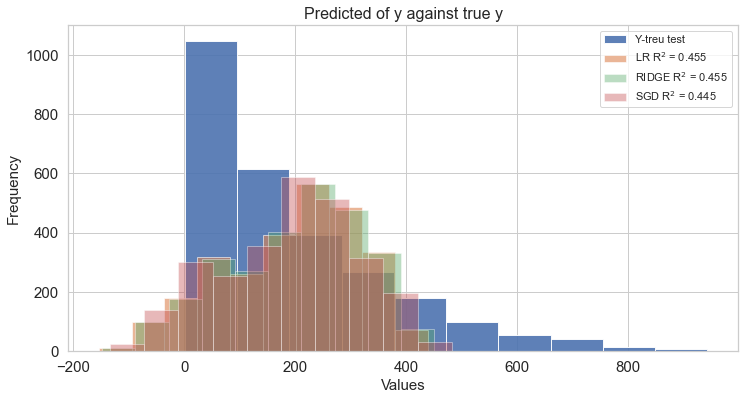

In [1119]:
y_test.plot.hist(alpha=0.9, label='Y-treu test',legend=True)
predictions_true['LR'].plot.hist(alpha=0.6, label='LR R$^{2}$ = 0.455',legend=True)
predictions_true['RIDGE'].plot.hist(alpha=0.4, label='RIDGE R$^{2}$ = 0.455', legend=True)
predictions_true['SGD'].plot.hist(alpha=0.4, label='SGD R$^{2}$ = 0.445', legend=True)
plt.xticks(rotation=0, fontsize=15)
plt.yticks(rotation=0, fontsize=15)
plt.title(label='Predicted of y against true y', fontsize=16)
plt.xlabel('Values',fontsize=15)
plt.ylabel('Frequency', fontsize=15)
plt.show()

# I learned how to use pipelines sklearn and pipe from pandas :)
# I learned how to do things with statsmodel and produce graphs
# I applied almost all what we learned this week :)